In [7]:
import numpy as np
from matplotlib import pyplot as plt
from sympy import Eq, symbols, init_printing, simplify, Matrix
import time
init_printing()

In [8]:
# Пример
x_ = np.arange(15)
f_ = np.sin(x_)

N = len(x_)

In [9]:
# Разделённые разности
def f(arr, f_, dict_):
    if len(arr) == 1:
        return dict_[arr[0]]
    return (f(arr[1 :], f_, dict_) - f(arr[: len(arr) - 1], f_, dict_)) / (arr[len(arr) - 1] - arr[0])

In [28]:
class spline:
    def __init__(self, x_, f_):
        self.x, self.f = x_, f_
        self.h = np.zeros(N - 1)
        for i in range(N - 1):
            self.h[i] = x_[i + 1] - x_[i]
        self.dict_ = dict(zip(x_, f_))
        self.a, self.b, self.c, self.d = 0, 0, 0, 0
        self.matrix, self.sol, self.s = 0, 0, 0
        
    def coeffs1(self):
        x_, f_, h, dict_ = self.x, self.f, self.h, self.dict_
        a, b, c, d = np.zeros(N - 1), np.full(N - 1, 2), np.zeros(N - 1), np.zeros(N - 1)

        for i in range(1, N - 1):
            a[i] = h[i - 1] / (h[i - 1] + h[i])
        for i in range(N - 2):
            c[i] = h[i] / (h[i - 1] + h[i])
        for i in range(N - 1):
            if i == 0:
                arr = [x_[0], x_[1], x_[2]]
            elif i == N - 2:
                arr = [x_[N - 3], x_[N - 2], x_[N - 1]]
            else:
                arr = [x_[i - 1], x_[i], x_[i + 1]]
            d[i] = 6 * f(arr, f_, dict_)
        self.a, self.b, self.c, self.d = a, b, c, d
    
    def create_matrix(self):
        a, b, c = self.a, self.b, self.c
        A = np.zeros((N - 1, N - 1))
        for i in range(N - 1):
            if i == 0:
                A[i, i], A[i, i + 1] = b[i], c[i]
            elif i == N - 2:
                A[i, i - 1], A[i, i] = a[i], b[i]
            else:
                A[i, i - 1], A[i, i], A[i, i + 1] = a[i], b[i], c[i]
        self.matrix = A
    
    def solution(self):
        A, a, b, c, d = self.matrix, self.a, self.b, self.c, self.d
        p, q = np.zeros(N - 1), np.zeros(N - 1)
        p[0], q[0] = -c[0] / b[0], d[0] / b[0]
        for i in range(N - 2):
            p[i + 1] = -c[i] / (a[i] * p[i] + b[i])
            q[i + 1] = (d[i] - a[i] * q[i]) / (a[i] * p[i] + b[i])

        sol = np.zeros(N - 1)
        sol[N - 2] = (d[N - 2] - a[N - 2] * q[N - 2]) / (a[N - 2] * p[N - 2] + b[N - 2])
        j = N - 3
        for i in range(N - 2):
            sol[j] = sol[j + 1] * p[j + 1] + q[j + 1]
            j -= 1
        self.sol = sol
    
    def coeffs2(self):
        x_, f_, h, sol, dict_ = self.x, self.f, self.h, self.sol, self.dict_
        a, b, c, d = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

        a = f_
        c = np.concatenate([sol, [0]], axis = 0)

        b[0] = c[0] * h[0] / 3 + f([x_[0], x_[1]], f_, dict_)
        for i in range(1, N):
            b[i] = c[i] * h[i - 1] / 3 + c[i - 1] * h[i - 1] / 6 + f([x_[i - 1], x_[i]], f_, dict_)

        d[0] = c[0] / h[0]
        for i in range(1, N):
            d[i] = (c[i] - c[i - 1]) / h[i - 1]
        self.a, self.b, self.c, self.d = a, b, c, d
    
    def create_s(self):
        a, b, c, d, x_ = self.a, self.b, self.c, self.d, self.x
        x = symbols('x')
        s = Matrix(np.zeros(N))
        for i in range(N):
            s[i] = a[i] + b[i] * (x - x_[i]) + c[i] / 2 * (x - x_[i]) ** 2 + d[i] / 6 * (x - x_[i]) ** 3
        self.s = s

    def image(self):
        x, s, x_, f_ = symbols('x'), self.s, self.x, self.f
        fig, ax = plt.subplots(1, 1)
        ax.plot(x_[:int(N)], f_[:int(N)], '.', color = 'red', label = 'исходные данные')
        for i in range(1, int(N)):
            x__ = np.linspace(x_[i - 1], x_[i], num = 8)
            p = []
            for j in range(len(x__)):
                p.append(s[i].subs({x: x__[j]}))
            ax.plot(x__, p, '--', color = 'blue', label = 'сплайн')
            if i == 1:
                ax.legend()
                
    def print_(self):
        s = self.s
        for i in range(N):
            display(Eq(symbols('s_' + str(i + 1)), simplify(s[i])))
                
    def create_spline(self):
        self.coeffs1()
        self.create_matrix()
        self.solution()
        self.coeffs2()
        self.create_s()
        self.image()
        self.print_()

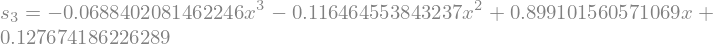

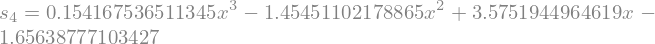

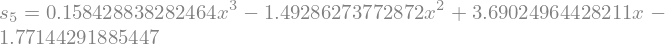

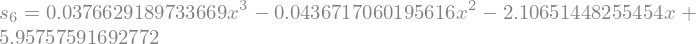

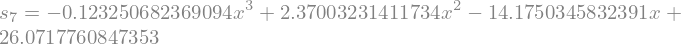

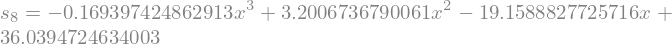

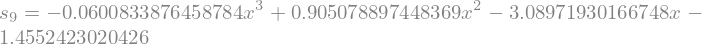

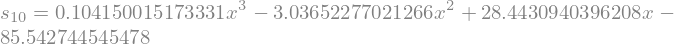

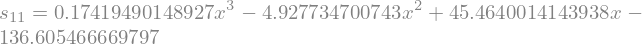

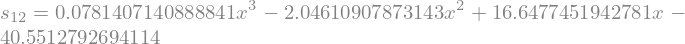

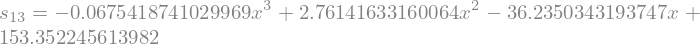

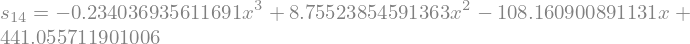

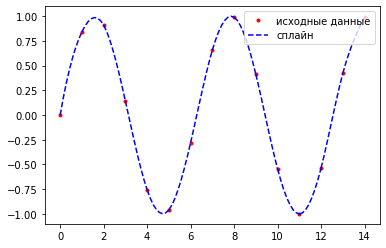

In [29]:
spl = spline(x_, f_)
spl.create_spline()